In [2]:
from keras.layers               import Input, Dense, GRU, LSTM, RepeatVector, merge
from keras.models               import Model, Sequential, load_model
from keras.layers.core          import Flatten
from keras.callbacks            import LambdaCallback
from keras.optimizers           import SGD, RMSprop, Adam
from keras.layers.wrappers      import Bidirectional as Bi
from keras.layers.wrappers      import TimeDistributed as TD
from keras.applications.vgg16   import VGG16 
from keras.callbacks import EarlyStopping, TensorBoard, ModelCheckpoint
from keras.layers.normalization import BatchNormalization as BN
from keras.layers.noise         import GaussianNoise as GN
from keras.preprocessing.image import load_img, img_to_array
from keras.preprocessing.text import one_hot
from keras.preprocessing.sequence import pad_sequences
from keras.utils import to_categorical
import numpy as np
import sys, os, io, json, re
from PIL import Image
import MeCab
import pandas as pd
import mojimoji
import collections
import matplotlib.pyplot as plt

Using TensorFlow backend.


In [3]:
"""学習データの準備"""

# m = MeCab.Tagger('-Ochasen')
m = MeCab.Tagger(' -d /usr/local/lib/mecab/dic/mecab-ipadic-neologd')
m.parse('')  #バグ回避

data = pd.read_csv('boketeScrapy/legend.csv')

In [4]:
"""
テキスト抽出

　形態素解析してリスト形式にする
"""

w_ys = []
for txt in data['txt']:
    txt_list = txt.split(",")
    for txt in txt_list:
        # 形態素解析
        ys = []
        tmp_ys = []
        only_symbol = True
        node = m.parseToNode(txt)
        while node:
            # surfaceで単語、featureで解析結果が取得できる
            surface = mojimoji.han_to_zen(node.surface, digit=False)
            features = node.feature.split(",")
            # feature = [品詞,品詞細分類1,品詞細分類2,品詞細分類3,活用形,活用型,原形,読み,発音]
            if features[0] == "BOS/EOS" and features[-3] == "*":
                node = node.next
                continue
            if features[0] == "記号":
                # 基本的に記号がキレイに処理できない様なので無視するが、形態素解析結果が全て記号だった時はそのまま使用する
                tmp_ys.append(surface)
            else:
                ys.append(surface)
                only_symbol = False
            node = node.next

        if only_symbol is True:
            tmp_ys.append("EOS")
            ys = tmp_ys
        else:
            ys.append("EOS")
        w_ys.append(ys)

print(w_ys)

[['仏の顔も三度', 'という', '言葉', 'を', '知り', '天使', 'は', '何', '度', 'な', 'の', 'か', '試し', 'て', 'み', 'た', 'ところ', '一', '度', 'も', '待っ', 'て', 'くれ', 'なかっ', 'た', 'EOS'], ['1', 'ねん', '1', 'くみ', 'よし', 'だ', 'さおり', 'EOS'], ['きのこの山', 'と', 'たけのこの里', 'で', 'は', 'きのこの山', 'の', '方', 'が', 'カロリー', 'が', '高い', 'EOS'], ['出ろ', '面会', 'の', '時間', 'だ', 'EOS'], ['そう', 'そして', 'やっ', 'て', 'は', 'いけ', 'ない', 'こと', 'は', '3つ', '歩きスマホ', '歩きタバコ', 'EOS'], ['お前', 'の', '手料理', '俺', 'に', 'しか', '作る', 'な', 'よ', 'EOS'], ['みんな', 'し', 'て', '喪中', '喪中', 'って', '俺', 'が', '一体', '何', 'し', 'た', 'って', 'いう', 'ん', 'だ', 'EOS'], ['ハイ', 'チーズ', 'EOS'], ['飛行機', 'の', '窓', 'から', '夕焼け', 'が', 'きれい', 'だっ', 'た', 'ので', '友人', 'を', '起こそ', 'う', 'と', '思っ', 'た', 'が', '楽し', 'そう', 'に', '寝言', 'を', '言っ', 'て', 'い', 'た', 'ので', 'やめ', 'た', 'EOS'], ['パソコン', 'を', '使う', 'お仕事', 'です', 'パソコン', 'の', '使い方', 'を', '私達', 'に', '教え', 'て', 'くれる', '人', 'を', '募集', 'し', 'て', 'い', 'ます', 'EOS'], ['ハア', 'ハア', 'お前', 'ら', '全員', '顔', '覚え', 'た', 'から', 'な', 'EOS'], ['ひで', 'ー', 'な', '母さん', '俺', 'の', '名前'

In [5]:
'''
単語のIndex作成

形態素解析した単語の一覧辞書を作る
'''

corpus = []
for word in w_ys:
    corpus.extend(word)

"""
登場回数降順のタプルにする
collections.Counter(corpus).items(): 単語がkey, 出現回数がvalueとなる辞書を作り、[(key, val), (key, val), ...]に変換
key=lambda x:x[1]: sortedでvalをソートキーに指定
reverse=True: 降順
"""
# FIXME: sorted()引数key(登場回数)が同値の場合, jupyterのkernel再起動の度に並び順が変わってしまう => 出力される文字が変わってしまう
# => JSONに吐き出す
word_id = [ (k,v) for k,v in sorted(collections.Counter(corpus).items(), key=lambda x:x[1], reverse=True) if k!="EOS" ]
# {単語:（１から始まる）ID}という辞書を作成
word_id = { k:e for e, (k,v) in enumerate(word_id, start = 1)}
word_id["EOS"] = 0
print(word_id)

{'きい': 448, '断っ': 1061, '火事': 449, '川越シェフ': 235, '新': 450, '枚': 236, '人類': 451, 'ハゲジジイ': 452, 'オシッコ': 453, 'もしかして': 455, '轢い': 456, '下る': 912, 'たよ': 237, '額': 458, 'ピン': 459, '会計': 238, '間違え': 460, 'Ａ': 461, '辿っ': 462, 'まだ': 239, '転校': 463, 'さま': 464, 'しっかり': 465, 'なる': 65, '本心': 466, 'これから': 135, '開け': 467, '妖精': 468, 'ググ': 469, '万引きＧメン': 470, '引き金': 471, 'こちら': 240, 'ツボる': 472, 'グサッ': 136, '小６': 473, 'やる気': 474, 'きのこの山': 96, 'ぞ': 137, '優しい世界': 475, '横': 476, 'だっ': 34, 'パンダ': 477, '恥ずかしい': 478, 'な！': 241, '思っ': 138, '通じ': 479, '3勝': 480, '以下': 481, 'たけのこの里': 242, '入浴': 482, '塗りたて': 793, '生え': 484, 'アフリカ': 485, 'コレ': 243, '山下': 486, '着地': 487, 'Ｒａｄｉｏ': 598, 'な': 13, 'フレーム': 488, '果': 489, '落とし': 245, 'あげ': 490, 'ドーナツ': 491, 'トトロ': 492, '恐': 493, 'とんでも': 920, '腰': 495, '探し': 496, '医者': 497, '例': 498, 'シャンプー': 499, '後輩': 770, '先週': 500, 'チョコレートフォンデュ': 501, '隙': 923, 'ぜ': 97, '素敵': 247, 'つけれ': 502, 'こ': 66, '戻っ': 319, '怖く': 605, '今': 140, 'デスノート': 248, '人手': 504, '相合い傘': 141, 'めて': 505, '

In [6]:
'''
逆引き辞書作成

{ID: 単語}という辞書を作成
'''

id_word = {v:k for k,v in word_id.items()}
print(id_word)

{0: 'EOS', 1: 'の', 2: 'て', 3: 'た', 4: 'が', 5: 'に', 6: 'を', 7: 'と', 8: 'し', 9: 'は', 10: 'で', 11: 'ない', 12: 'だ', 13: 'な', 14: 'よ', 15: 'から', 16: 'ん', 17: 'たら', 18: 'も', 19: 'か', 20: 'です', 21: 'てる', 22: 'き', 23: 'う', 24: 'っ', 25: 'くさい', 26: 'ます', 27: 'い', 28: 'ね', 29: 'れ', 30: '言っ', 31: 'こと', 32: 'この', 33: '私', 34: 'だっ', 35: 'って', 36: '人', 37: '俺', 38: 'する', 39: 'ので', 40: '来', 41: 'ー', 42: '何', 43: 'お前', 44: 'やっ', 45: 'そう', 46: 'さ', 47: 'よう', 48: 'いい', 49: '方', 50: 'だけ', 51: 'パソコン', 52: 'せ', 53: 'お', 54: '子', 55: 'みんな', 56: 'のに', 57: 'なっ', 58: 'わ', 59: 'これ', 60: 'ら', 61: 'どう', 62: '一', 63: 'じゃ', 64: 'くれ', 65: 'なる', 66: 'こ', 67: 'まで', 68: '食っ', 69: '名前', 70: 'こい', 71: 'ぶつ', 72: '中', 73: '顔', 74: '母さん', 75: 'へ', 76: 'たべ', 77: 'み', 78: '僕', 79: '度', 80: '自分', 81: '食べ', 82: '次', 83: '出す', 84: '下さい', 85: 'それ', 86: 'ある', 87: '苦しい', 88: 'いけ', 89: 'や', 90: '落ち', 91: '使い方', 92: 'ねぇ', 93: 'なんか', 94: 'ご', 95: '時', 96: 'きのこの山', 97: 'ぜ', 98: '餡', 99: '喪中', 100: 'いる', 101: '待っ', 102: 'おき', 103: '母', 10

In [7]:
print("All words:\t\t", len(word_id))
# 平均単語数
print("Avg. boke length:\t", np.mean(np.array([len(w) for w in w_ys])))

All words:		 1386
Avg. boke length:	 11.5527777778


In [8]:
'''
単語リストのパディング

MAX_LEN = 最大単語数
（上記の平均単語数を元に決める）
''' 

MAX_LEN = 15  # てきとう

# 形態素解析した単語を全てIDに変換する
id_ys = [[word_id[w] for w in ws] for ws in w_ys]

# MAX_LENを超えた要素に対して、超過分のtruncate、不足分を"EOS"でpddingを行う処理
# 返り値は２次元numpy配列
vec_ys = pad_sequences(id_ys, maxlen=MAX_LEN, padding='post', truncating="post", value=word_id["EOS"])

print("vector shape:\t",vec_ys.shape)

vector shape:	 (360, 15)


In [9]:
'''
単語リストをone-hot(0-1)化
'''

# print(vec_ys[0])
# [445 113 187   6 339 303   9  43  81  13   1  18 204   2  72]

# to_categorical(): クラスベクトルa（0からlen(word_id)までの整数）を categorical_crossentropyとともに用いるためのバイナリのクラス行列に変換
Y = np.array([to_categorical(a, len(word_id)) for a in vec_ys])
print(Y)

[[[ 0.  0.  0. ...,  0.  0.  0.]
  [ 0.  0.  0. ...,  0.  0.  0.]
  [ 0.  0.  0. ...,  0.  0.  0.]
  ..., 
  [ 0.  0.  0. ...,  0.  0.  0.]
  [ 0.  0.  1. ...,  0.  0.  0.]
  [ 0.  0.  0. ...,  0.  0.  0.]]

 [[ 0.  0.  0. ...,  0.  0.  0.]
  [ 0.  0.  0. ...,  0.  0.  0.]
  [ 0.  0.  0. ...,  0.  0.  0.]
  ..., 
  [ 1.  0.  0. ...,  0.  0.  0.]
  [ 1.  0.  0. ...,  0.  0.  0.]
  [ 1.  0.  0. ...,  0.  0.  0.]]

 [[ 0.  0.  0. ...,  0.  0.  0.]
  [ 0.  0.  0. ...,  0.  0.  0.]
  [ 0.  0.  0. ...,  0.  0.  0.]
  ..., 
  [ 1.  0.  0. ...,  0.  0.  0.]
  [ 1.  0.  0. ...,  0.  0.  0.]
  [ 1.  0.  0. ...,  0.  0.  0.]]

 ..., 
 [[ 0.  0.  0. ...,  0.  0.  0.]
  [ 0.  0.  0. ...,  0.  0.  0.]
  [ 0.  0.  0. ...,  0.  0.  0.]
  ..., 
  [ 1.  0.  0. ...,  0.  0.  0.]
  [ 1.  0.  0. ...,  0.  0.  0.]
  [ 1.  0.  0. ...,  0.  0.  0.]]

 [[ 0.  0.  0. ...,  0.  0.  0.]
  [ 0.  0.  0. ...,  0.  0.  0.]
  [ 0.  0.  0. ...,  0.  0.  0.]
  ..., 
  [ 1.  0.  0. ...,  0.  0.  0.]
  [ 1.  0.  0. ...,  

In [10]:
"""画像読み込み"""
X = []
for image_txt in data['images']:
    image_list = image_txt.strip('[]')
    images = re.findall(r'{.+?}', image_list)
    for image in images:
        image = image.replace("'", '"')
        image = json.loads(image)
        path = 'boketeScrapy/img/' + image['path']
        img = load_img(path, target_size=(150, 150))
        x = img_to_array(img)
        X.append(x)

X = np.asarray(X)
print(X.shape)

(360, 150, 150, 3)


In [11]:
"""
モデル生成

Getting started with the Keras functional API: https://keras.io/ja/getting-started/functional-api-guide/
"""

units = 768

input_tensor = Input(shape=(150, 150, 3))
vgg_model = VGG16(include_top=False, weights='imagenet', input_tensor=input_tensor)
vgg_x = vgg_model.layers[-1].output
vgg_x = Flatten()(vgg_x)
vgg_x = Dense(units)(vgg_x)

# 入力が文章ならRepeatVectorの数は単語数になるが、今回は画像なので適正値が不明
inputs = RepeatVector(MAX_LEN)(vgg_x)
encoded = LSTM(units)(inputs)
encoder = Model(input_tensor, encoded)

DIM = len(word_id)
x = RepeatVector(MAX_LEN)(encoded)
x = Bi(LSTM(units, return_sequences=True))(x)
# 入力次元は単語辞書と同じサイズになる
decoded = TD(Dense(DIM, activation='softmax'))(x)

model = Model(input_tensor, decoded)

# for i, layer in enumerate(model.layers): # default 15
#   print( i, layer )

for layer in model.layers[:18]: # 18 is max of VGG16
  layer.trainable = False

model.compile(optimizer=Adam(), loss="categorical_crossentropy", metrics=["accuracy"])

model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 150, 150, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 150, 150, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 150, 150, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 75, 75, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 75, 75, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 75, 75, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 37, 37, 128)       0         
__________

In [14]:
"""学習実行"""
epoch_cnt = 300
batch_size = 8  # １回目=32, ２回目=16, 3回目=8

path = 'model/weights.{epoch:02d}-{loss:.2f}-{acc:.2f}.hdf5'
model_checkpoint = ModelCheckpoint(path, monitor='loss', verbose=1, save_best_only=True, mode='auto')
early_stopping = EarlyStopping(monitor='loss', patience=8, verbose=1, mode='auto')
# history = model.fit(X, Y,  shuffle=True, batch_size=batch_size, epochs=epoch_cnt, verbose=1, validation_split=0.1, callbacks=[model_checkpoint, early_stopping] )
history = model.fit(X, Y,  shuffle=True, batch_size=batch_size, epochs=epoch_cnt, verbose=1, callbacks=[model_checkpoint, early_stopping] )

Epoch 1/300
360/360 [==============================] - 3818s 11s/step - loss: 4.5504 - acc: 0.4272
Epoch 2/300
360/360 [==============================] - 326s 904ms/step - loss: 3.6061 - acc: 0.4339
Epoch 3/300
360/360 [==============================] - 7454s 21s/step - loss: 3.1922 - acc: 0.4494
Epoch 4/300
360/360 [==============================] - 21841s 61s/step - loss: 2.8815 - acc: 0.4659
Epoch 5/300
360/360 [==============================] - 21845s 61s/step - loss: 2.6463 - acc: 0.4833
Epoch 6/300
360/360 [==============================] - 8909s 25s/step - loss: 2.4965 - acc: 0.4920
Epoch 7/300
360/360 [==============================] - 232s 644ms/step - loss: 2.4164 - acc: 0.4913
Epoch 8/300
360/360 [==============================] - 218s 607ms/step - loss: 2.3130 - acc: 0.4952
Epoch 9/300
360/360 [==============================] - 244s 679ms/step - loss: 2.2007 - acc: 0.5120
Epoch 10/300
360/360 [==============================] - 234s 649ms/step - loss: 2.1576 - acc: 0.5250
Ep

360/360 [==============================] - 189s 525ms/step - loss: 1.7352 - acc: 0.5628
Epoch 34/300
360/360 [==============================] - 188s 523ms/step - loss: 1.6219 - acc: 0.5822
Epoch 35/300
360/360 [==============================] - 190s 529ms/step - loss: 1.5091 - acc: 0.5919
Epoch 36/300
360/360 [==============================] - 3872s 11s/step - loss: 1.4491 - acc: 0.6150
Epoch 37/300
360/360 [==============================] - 18223s 51s/step - loss: 1.3484 - acc: 0.6256
Epoch 38/300
360/360 [==============================] - 410s 1s/step - loss: 1.3258 - acc: 0.6274
Epoch 39/300
360/360 [==============================] - 197s 548ms/step - loss: 1.3182 - acc: 0.6444
Epoch 40/300
360/360 [==============================] - 192s 534ms/step - loss: 1.2838 - acc: 0.6572
Epoch 41/300
360/360 [==============================] - 224s 623ms/step - loss: 1.3231 - acc: 0.6461
Epoch 42/300
360/360 [==============================] - 187s 519ms/step - loss: 1.2278 - acc: 0.6637
Epoch 4

Epoch 68/300
360/360 [==============================] - 185s 514ms/step - loss: 1.0364 - acc: 0.6959
Epoch 00068: early stopping


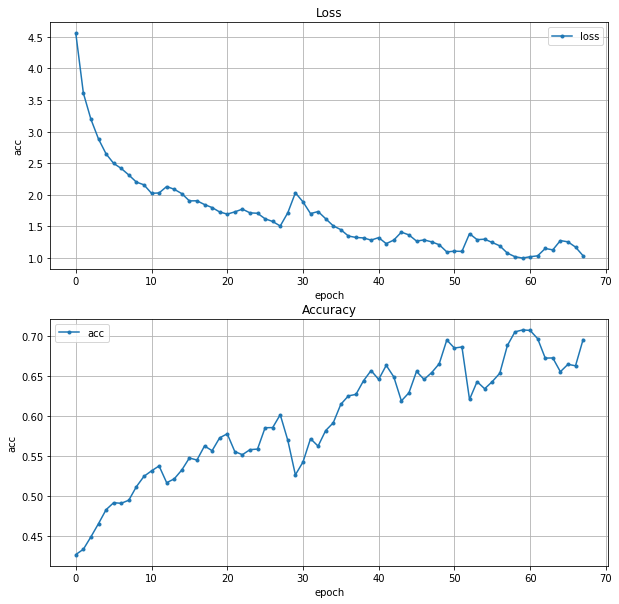

In [15]:
# 学習結果をグラフ表示

# plot results
loss = history.history['loss']
# val_loss = history.history['val_loss']

acc = history.history['acc']
# val_acc = history.history['val_acc']

plt.figure(figsize=(10,10))
plt.subplot(2,1,1)
plt.title('Loss')
epochs = len(loss)
plt.plot(range(epochs), loss, marker='.', label='loss')
# plt.plot(range(epochs), val_loss, marker='.', label='val_loss')
plt.legend(loc='best')
plt.grid()
plt.xlabel('epoch')
plt.ylabel('acc')

plt.subplot(2,1,2)
plt.title('Accuracy')
plt.plot(range(epochs), acc, marker='.', label='acc')
# plt.plot(range(epochs), val_acc, marker='.', label='val_acc')
plt.legend(loc='best')
plt.grid()
plt.xlabel('epoch')
plt.ylabel('acc')
plt.show()

In [12]:
"""学習済みモデルをロード"""

# model.load_weights('model/bak/weights.30-1.58-0.63_unit768_2.hdf5')
# model = load_model('model/bak/weights.30-1.58-0.63_unit768_2.hdf5')

In [ ]:
# ボケ実行

# 学習に使用したデータ
odai_train = [
    "77543a29fa8cbdf7e755bfe58eb3e7c21f46b676",
    "b9a9d4c39ebdc1915fdc14431a7b1104f39394bd",
    "fdd85d19685d3dc980062f4c98649c298457ded2",
    "eb231af7d09c77179947f589afd6ab114aef9712",
    "0111bb43aa0dd468796396258f524ab4ad153919"
]

# 未学習の検証データ
odai_test = [
    "3292c5431dfb57e53f5cdf54a9c8c9d6-400-300-id-658",
    "YuichiMasumiya",
    "1473684207",
    "hn1096-ch-money02b",
    "4104-1",
    "trump20160404-top-1000x600",
    "Trump-1-770x410"
]

f = odai_train[1]
# f = odai_test[4]

path_test = "odai/" + f + ".jpg"

X_test = []
img_test = load_img(path_test, target_size=(150, 150))
x_test = img_to_array(img_test)
X_test.append(x_test)
X_test = np.asarray(X_test)

# 予測実行
pred = model.predict(X_test)
print(pred.shape)

im = Image.open(path_test)
im.show()

# 予測結果を元にid_wordから文字列を抽出
for p in pred[0]:
    if np.argmax(p) == 0:
        continue
    print(id_word[int(np.argmax(p))], end=" ")